<a href="https://colab.research.google.com/github/tdat97/captcha_OCR/blob/master/OCR_captcha_%EC%88%98%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://keras.io/examples/vision/captcha_ocr/

### Download Dataset

In [ ]:
!wget https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -q captcha_images_v2.zip

--2021-09-04 09:41:46--  https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip [following]
--2021-09-04 09:41:47--  https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9075967 (8.7M) [application/zip]
Saving to: ‘captcha_images_v2.zip’

captcha_images_v2.z 100%[===================>]   8.66M  --.-KB/s    in 0.1s    

2021-09-04 09:41:48 (59.5 MB/s) - ‘captcha_images_v2.zip’

In [ ]:
import os
from glob import glob

img_paths = sorted(glob('./captcha_images_v2/*.png'))
get_label = lambda x:os.path.splitext(os.path.basename(x))[0]
labels = list(map(get_label, img_paths))
chars = set(''.join(labels))
max_length = max([len(label) for label in labels])

print("Number of images found: ", len(img_paths))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(chars))
print("Characters present: ", chars)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'x', 'd', '2', '8', 'b', 'w', 'p', 'n', 'y', 'c', 'e', '4', 'f', '5', 'g', '7', '3', '6', 'm'}


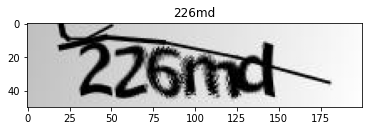

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread(img_paths[0])
label = labels[0]

plt.title(label)
plt.imshow(img)

### Split Data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(img_paths, labels, test_size=0.1, random_state=2021)

print(len(x_train), len(y_train))
print(len(x_valid), len(y_valid))

936 936
104 104


### Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# layers.experimental.preprocessing.StringLookup

# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(chars), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

img_width = 200
img_height = 50

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32) # 0~255 -> 0~1
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return img, label

### Dataset obj

In [ ]:
import tensorflow as tf

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

loss_fn = keras.backend.ctc_batch_cost

def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64") # 16
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64") # 50
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64") # 5

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = loss_fn(y_true, y_pred, input_length, label_length)
    return loss

def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same", 
                      kernel_initializer="he_normal", name="Conv2D_1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="Pool_1")(x) # (100, 25, 32)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same",
                      kernel_initializer="he_normal", name="Conv2D_2")(x)
    x = layers.MaxPooling2D((2, 2), name="Pool_2")(x) # (50, 12, 64)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x) # (50, 768)
    # x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Conv1D(64, 1, activation='relu', name='Conv1D_1')(x)
    x = layers.Dropout(0.2, name='Dropout')(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name='Bi_LSTM_1')(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25), name='Bi_LSTM_2')(x)

    # Output layer
    # x = layers.Dense(len(char_to_num.get_vocabulary()) + 1,
    #                  activation="softmax", name="dense2")(x)
    x = layers.Conv1D(len(char_to_num.get_vocabulary()) + 1, 1, activation='softmax', name='Conv1D_2')(x)

    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=x, name="ocr_model_v1")

    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=CTC_loss)

    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 200, 50, 32)       320       
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 100, 25, 64)       18496     
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 50, 12, 64)        0         
_________________________________________________________________
Reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 50, 64)           

In [ ]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 44s 120ms/step - loss: 20.3765 - val_loss: 16.3082
Epoch 2/100
59/59 [==============================] - 5s 78ms/step - loss: 16.3629 - val_loss: 16.3050
Epoch 3/100
59/59 [==============================] - 5s 80ms/step - loss: 16.3491 - val_loss: 16.3138
Epoch 4/100
59/59 [==============================] - 5s 79ms/step - loss: 16.3446 - val_loss: 16.3197
Epoch 5/100
59/59 [==============================] - 5s 79ms/step - loss: 16.3327 - val_loss: 16.3177
Epoch 6/100
59/59 [==============================] - 5s 78ms/step - loss: 16.3246 - val_loss: 16.3176
Epoch 7/100
59/59 [==============================] - 5s 78ms/step - loss: 16.3086 - val_loss: 16.3012
Epoch 8/100
59/59 [==============================] - 5s 80ms/step - loss: 16.3027 - val_loss: 16.2848
Epoch 9/100
59/59 [==============================] - 5s 79ms/step - loss: 16.2710 - val_loss: 16.2485
Epoch 10/100
59/59 [==============================] - 6s 96ms/step - loss: 16.20

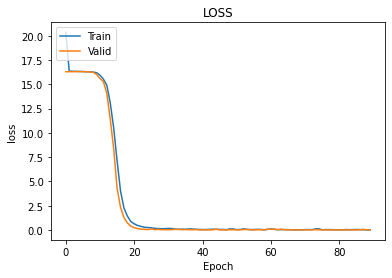

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LOSS')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

class CTCDecodeLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(CTCDecodeLayer, self).__init__(**kwargs)
        self.decoder = keras.backend.ctc_decode
    
    def __call__(self, y_pred):
        shape = tf.shape(y_pred)
        input_len = tf.ones(shape[0]) * tf.cast(shape[1], dtype=tf.float32)
        results = self.decoder(y_pred, input_length=input_len, greedy=True)[0][0][:,:max_length]
        return tf.strings.reduce_join(num_to_char(results), axis=1)

image = layers.Input(shape=(img_width, img_height, 1), name='Image')
y_pred = model(image, training=False)
decoded = CTCDecodeLayer(name='CTC_Decode')(y_pred)
inference_model = tf.keras.Model(inputs=image, outputs=decoded)

inference_model.summary()

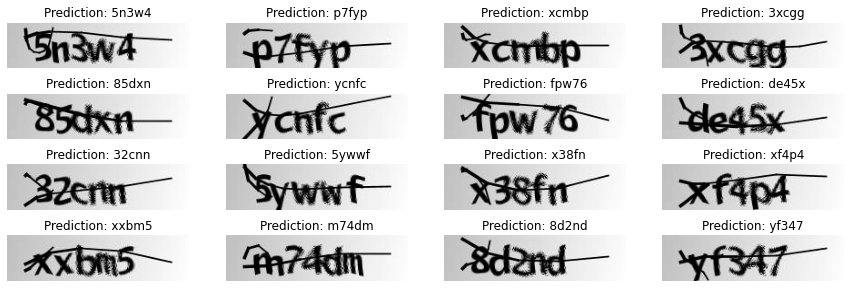

In [ ]:
import numpy as np

for batch in validation_dataset.take(1):
    batch_images, batch_labels = batch

    batch_preds = inference_model.predict(batch_images)
    batch_labels = tf.strings.reduce_join(num_to_char(batch_labels), axis=1).numpy()

    batch_preds = list(map(lambda x:x.decode('utf-8'), batch_preds))
    batch_labels = list(map(lambda x:x.decode('utf-8'), batch_labels))

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(batch_preds)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {batch_preds[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
np.argmax(preds[13], axis=1)

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 19, 20, 20, 20,
       16, 16, 20, 20, 20, 20, 12, 12, 20, 20, 20, 20,  2,  2, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19])

In [ ]:
aa = np.ones((3, 5, 4))

# 평소
# ll = layers.Dropout(0.5, input_shape=(5,4), noise_shape=[3,5,4])
# channel wise
ll = layers.Dropout(0.5, input_shape=(5,4), noise_shape=[3,1,4])

ll(aa, training=True)

<tf.Tensor: shape=(3, 5, 4), dtype=float32, numpy=
array([[[0., 2., 2., 0.],
        [0., 2., 2., 0.],
        [0., 2., 2., 0.],
        [0., 2., 2., 0.],
        [0., 2., 2., 0.]],

       [[2., 2., 0., 0.],
        [2., 2., 0., 0.],
        [2., 2., 0., 0.],
        [2., 2., 0., 0.],
        [2., 2., 0., 0.]],

       [[0., 0., 0., 2.],
        [0., 0., 0., 2.],
        [0., 0., 0., 2.],
        [0., 0., 0., 2.],
        [0., 0., 0., 2.]]], dtype=float32)>